---

<img src="../images/anchormen-logo.png" width="500">

---

# Exercise: Plotting Live Flight Data 


In this exercise we are going to use live flight data and use it to visualize the location of airplanes on an interactive map.

**The first part that deals with data retrieval has been done already. Your task is to finish the visualization part.**


## Data Source

This script retrieves data from The OpenSky Network: https://opensky-network.org/

The OpenSky Network has a free open-source API for real-time air traffic data. In its current version it allows users to retrieve live (and partially historical data). The data is retrieved by a network of ADS-B receivers and consists of

- ICAO 24-bit transponder ID to identify the aircraft
- the flight's callsign
- aircraft's current location (latitude, longitude, altitude)
- aircraft's current horizontal and vertical velocity plus heading
- Unix timestamps which indicate the age of each field

It's a REST API which provides all these data in JSON. They also provide simple Java and Python bindings.

Their official API documentation can be found at: https://opensky-network.org/apidoc/

The sources for the Java and Python bindings can be found on github: https://github.com/openskynetwork/opensky-api

## Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
import mplleaflet

%matplotlib inline

## Functions

In [2]:
def unixtime_to_datetime(time):
    if(np.isnan(time)):
        return np.nan
    else:
        return(datetime.datetime.fromtimestamp(time))

def clean_opensky_dataframe(df):
    # Create variables from 'states' list
    df['icao24'] = df.apply(lambda row: row.states[0], axis=1)
    df['callsign'] = df.apply(lambda row: row.states[1], axis=1)
    df['origin_country'] = df.apply(lambda row: row.states[2], axis=1)
    df['time_position'] = df.apply(lambda row: row.states[3], axis=1)
    df['time_velocity'] = df.apply(lambda row: row.states[4], axis=1)
    df['longitude'] = df.apply(lambda row: row.states[5], axis=1)
    df['latitude'] = df.apply(lambda row: row.states[6], axis=1)
    df['altitude'] = df.apply(lambda row: row.states[7], axis=1)
    df['on_ground'] = df.apply(lambda row: row.states[8], axis=1)
    df['velocity'] = df.apply(lambda row: row.states[9], axis=1)
    df['heading'] = df.apply(lambda row: row.states[10], axis=1)
    df['vertical_rate'] = df.apply(lambda row: row.states[11], axis=1)
    df['sensors'] = df.apply(lambda row: row.states[12], axis=1)

    # Drop 'states'
    df.drop('states', axis=1, inplace=True)

    # Convert timestamps
    df['time'] = df['time'].apply(unixtime_to_datetime)
    df['time_position'] = df['time_position'].apply(unixtime_to_datetime)
    df['time_velocity'] = df['time_velocity'].apply(unixtime_to_datetime)
    
    # Remove entries with unknown longitude or latitude
    df = df.dropna(subset=['longitude', 'latitude'])
    
    return(df)

## Retrieve Data from REST API

See documentation: https://opensky-network.org/apidoc/rest.html

In [3]:
# Read from OpenSky API
df_airplanes = pd.read_json("https://opensky-network.org/api/states/all")

# Clean dataframe
df_airplanes = clean_opensky_dataframe(df_airplanes)
df_airplanes.head(3)

,time,icao24,callsign,origin_country,time_position,time_velocity,longitude,latitude,altitude,on_ground,velocity,heading,vertical_rate,sensors
0,2019-09-13 12:00:50,88044b,AIQ3245,Thailand,2019-09-13 12:00:50,2019-09-13 12:00:50,100.2095,13.9765,2903.22,False,148.29,272.39,15.93,None
2,2019-09-13 12:00:50,aa56db,UAL1164,United States,2019-09-13 12:00:49,2019-09-13 12:00:49,-88.8900,40.6069,10668.00,False,251.14,91.53,0.00,None
3,2019-09-13 12:00:50,7c6b2e,VGG,Australia,2019-09-13 12:00:48,2019-09-13 12:00:49,152.2070,-27.1877,2689.86,False,86.09,114.73,0.00,None


## Visualization: plot airplanes on an interactive leaflet background

Can you figure out how to plot the airplane locations on a (zoomable) leaflet background?

*Hint: First set the axes, then plot the airplane locations, followed by an mplleaflet command*

Notes:
- *With too many datapoints, mpleaflet may not work properly. Reduce the number of datapoints if necessary, or use mplleaflet.show() instead of mplleaflet.display()*
- *Also note that mplleaflet does not respond well to missing coordinates.*

In [4]:
# Interactive visualization
fig, ax = plt.subplots(figsize=(16,16))
df_airplanes.plot(x='longitude', y='latitude', kind='scatter', color='red', s=2, ax=ax)
mplleaflet.show(fig=fig)

## Single function to obtain and visualize airplane location data

- Now write a single function that loads the (live) airplane location data and plots them on an interactive background

In [5]:
def visualize_live_airplanes():
    # Read from OpenSky API
    df_airplanes = pd.read_json("https://opensky-network.org/api/states/all").head(1000)

    # Clean dataframe
    df_airplanes = clean_opensky_dataframe(df_airplanes)
    
    # Visualize
    fig, ax = plt.subplots(figsize=(16,16))
    df_airplanes.plot(x='longitude', y='latitude', kind='scatter', s=2, 
                  color='red', ax=ax)
    fig = mplleaflet.display(fig=fig)
    
    return(fig)

In [6]:
# Let's plot some live data!
visualize_live_airplanes()

/anaconda3/envs/spatial/lib/python3.7/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Alternative: Plot airplanes using pandas (on top of geopandas background)

In [7]:
def visualize_airplanes(longitudes=[-10,40], latitudes=[30,70]):
    # Read from OpenSky API
    df_airplanes = pd.read_json("https://opensky-network.org/api/states/all")

    # Clean dataframe
    df_airplanes = clean_opensky_dataframe(df_airplanes)
    
    # Load natural earth geodataframe
    gdf_countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    # Plot airplane locations on top of natural earth
    fig, ax = plt.subplots(figsize=(16,16), subplot_kw={'aspect':'equal'})
    ax.set_xlim(longitudes)
    ax.set_ylim(latitudes)
    ax.set_axis_off()
    ax.set_title('Airplane locations', size = 20)
    gdf_countries.plot(color='lightgrey', ax=ax)
    fig = df_airplanes.plot(x='longitude', y='latitude', kind='scatter', color='red', s=2, ax=ax)
    
    return(fig)

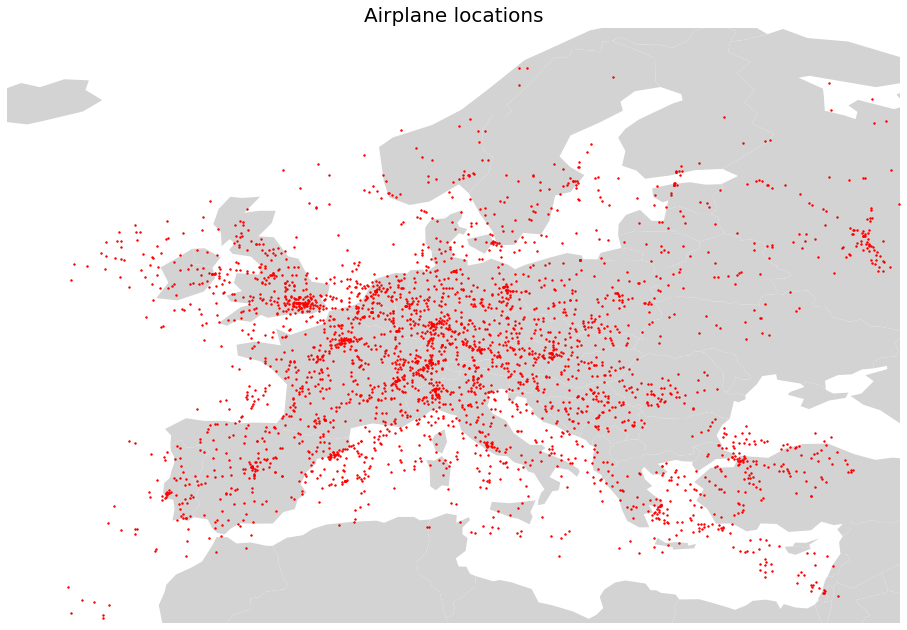

In [8]:
visualize_airplanes(longitudes=[-20,40], latitudes=[30,70])

## Optional: Improve your visualization as you wish

- For example: zooming in on The Netherlands and removing other airplanes
- Giving airplanes different colors
- Check out Folium for interactive maps (instead of mplleaflet)!
- Check with your neighbor how he/she has done the assignment

### Folium Maps

In [9]:
# Visualization functions
import folium 
from folium import plugins

def visualize_points_folium(df, x_coord='longitude', y_coord='latitude', name_coord='callsign', zoom = 4):
    """Visualize lat/lon locations on map using Folium"""
    
    # Bit of cleaning
    df = df.dropna(subset=[x_coord, y_coord])
    
    # Determine mean lon/lat coordinates
    center_lon, center_lat = df[[x_coord, y_coord]].mean()

    # Initialize map
    map = folium.Map(location = [center_lat, center_lon], zoom_start = zoom, tiles='Stamen Terrain')
 
    # Instantiate a mark cluster object for the locations in the dataframe
    locations = plugins.MarkerCluster().add_to(map)
 
    # Loop through the dataframe and add each data point to the mark cluster
    for lon, lat, name, in zip(df[x_coord], df[y_coord], df[name_coord]):
        
        folium.Marker(
            location=[lat, lon],
            icon=None,
            popup = folium.Popup(name),
        ).add_to(locations)
    
    # Display map
    return(map)

In [10]:
# Read from OpenSky API
df_airplanes = pd.read_json("https://opensky-network.org/api/states/all")

# Clean dataframe
df_airplanes = clean_opensky_dataframe(df_airplanes).head(1000)

visualize_points_folium(df_airplanes, 
                        x_coord='longitude', 
                        y_coord='latitude', 
                        name_coord='callsign',
                        zoom = 4)